# ETL for the Review dimension

In this dimension we hold information relative to reviews given by airbnb guests.

![Host schema](../review_schema.png)

**Hierarchies and data granularity**

There are no hierarchical relationships in this dimension.
As for granularity, you will see that efforts were made in order to ensure that the grain is as fine as the data distribution allows us to have it.

In [246]:
# Libraries
import psycopg2 as pg
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import psycopg2.extras
import math
import numpy as np
import seaborn as sns

### Read csv files

In [106]:
# Main dataset
df = pd.read_csv("../data/listings_al.csv")

## EDA and missing data

Singling out the columns of interest for this dimension, we analyse the distribution of missing values.

In [247]:
def missing_data(df, columns):
    """Calculates the amount of missing data in given DataFrame's selected columns"""
    df_graph = df[columns]
    # missing data
    total = df_graph.isnull().sum().sort_values(ascending=False)
    percent = (df_graph.isnull().sum()/df_graph.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data)
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x='index',y = 'Percent', data= missing_data.reset_index())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    return ax

#IN BAR CHARTS, SET THE VALUE ABOVE EACH BAR
def set_bar_amount(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate("{0:.2f}%".format(p.get_height()*100), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', rotation=0, xytext=(0, 10),
            textcoords='offset points')

                             Total   Percent
review_scores_location        2170  0.126398
review_scores_communication   2169  0.126340
review_scores_accuracy        2168  0.126281
review_scores_cleanliness     2167  0.126223
review_scores_rating          2166  0.126165


Text(0.5, 1.0, 'Review dimension missing values')

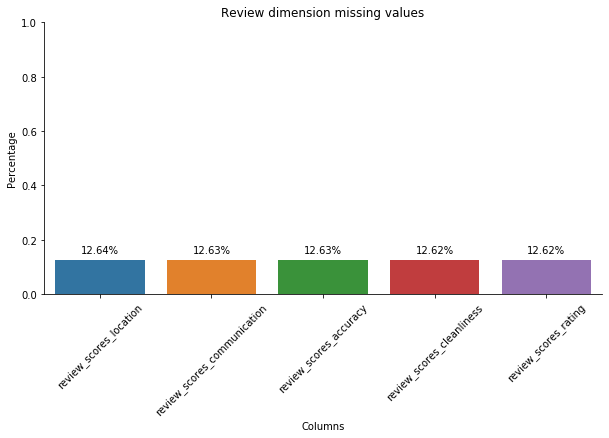

In [248]:
columns = [
'review_scores_rating', 
'review_scores_accuracy', 
'review_scores_cleanliness', 
'review_scores_communication', 
'review_scores_location', 
]

ax = missing_data(df,columns)
set_bar_amount(ax)
ax.set_xlabel('Columns')
ax.set_ylabel('Percentage')
plt.ylim(0,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Review dimension missing values')

Looking at the missing data we think that it is reasonable to ignore the records which don't have any review information, since the bar plot suggests that some records are entirely empty.

One alternative could be setting a minimum number of non-null scores in order for the record to be considered. 

**How to categorize the numerical scores?**

In [260]:
def get_quantiles(df,column,num_quantiles):
    print(pd.qcut(df[column],5, duplicates='drop').value_counts())

Rating:

In [261]:
get_quantiles(df,'review_scores_rating', 5)

(19.999, 89.0]    3280
(93.0, 96.0]      3278
(89.0, 93.0]      3136
(98.0, 100.0]     2987
(96.0, 98.0]      2321
Name: review_scores_rating, dtype: int64


As we can see from this quantile distribution, it is reasonable to divide the rating in five categories: 'Bellow average', 'Average', 'Good', 'Very good', 'Excelent' (given that the average is 92.67 and std. deviation=8.07).

Accuracy, cleanliness, communication, location:

In [262]:
get_quantiles(df,'review_scores_accuracy', 5)

(9.0, 10.0]     10381
(1.999, 9.0]     4619
Name: review_scores_accuracy, dtype: int64


In [263]:
get_quantiles(df,'review_scores_cleanliness', 5)

(9.0, 10.0]     9180
(1.999, 9.0]    5821
Name: review_scores_cleanliness, dtype: int64


In [264]:
get_quantiles(df,'review_scores_communication', 5)

(9.0, 10.0]     11444
(1.999, 9.0]     3555
Name: review_scores_communication, dtype: int64


In [265]:
get_quantiles(df,'review_scores_location', 5)

(9.0, 10.0]     9579
(1.999, 9.0]    5419
Name: review_scores_location, dtype: int64


Given this data distribution it only makes sense to create two categories: Good (score>=9.0) or Bad (score<9.0)

### Transformation methods

In [107]:
# Check for missing values:
def is_nan(x):
    return (x != x)

In [108]:
def get_rating(score):
    if is_nan(score): return None
    if score < 88: return "Bellow average"
    if score < 93: return "Average"
    if score < 96: return "Good"
    if score < 99: return "Very good"
    if score < 100: return "Excelent"

In [109]:
def get_accuracy(score):
    if is_nan(score): return None
    if score < 9: return "Accurate description"
    return "Description is not accurate"

In [110]:
def get_cleanliness(score):
    if is_nan(score): return None
    if score < 9: return "Not clean"
    return "Clean"

In [111]:
def get_communication(score):
    if is_nan(score): return None
    if score < 9: return "Bad communication"
    return "Good communication"

In [112]:
def get_location(score):
    if is_nan(score): return None
    if score < 9: return "Bad location"
    return "Good location"

### Create clean dataframe

We will now use the methods described above to create each column of the dimension, extracting the data from the original dataset `df`.

In [113]:
listing_id = [i for i in df['id']]
ratings = [get_rating(s) for s in df['review_scores_rating']]
accuracy = [get_accuracy(s) for s in df['review_scores_accuracy']]
cleanliness = [get_cleanliness(s) for s in df['review_scores_cleanliness']]
communication = [get_communication(s) for s in df['review_scores_communication']]
location = [get_location(s) for s in df['review_scores_location']]

In [268]:
columns = ['listing_id','rating','accuracy','cleanliness','communication','location']

# Create dataframe
df_review_dimension = pd.DataFrame(np.stack((listing_id,ratings, accuracy, cleanliness,communication,
                                          location),axis=-1), columns = columns)
# Dataframe shape (rows, columns)
df_review_dimension.shape

(17168, 6)

**Remove records with null values:**

In [101]:
def delete_null_rows(df,columns):
    """Removes all records with any empty cells from input DataFrame"""
    processed_df = df[columns].copy()
    total_rows = processed_df.shape[0]
    delete_rows = []
    
    if processed_df.isnull().values.any(): # if there are any null values in DataFrame, process DataFrame
        for index, row in enumerate(processed_df.itertuples(), start = 0):
            if (pd.Series(row).isnull().values.any()): # if row has any null value
                delete_rows.append(index) # add row index to delete list
    
    processed_df.drop(df.index[delete_rows], inplace = True) # delete rows fr
    processed_df = processed_df.reset_index().drop('index', axis = 1)
    print('DataFrame contains {} rows. Deleted {} rows ({}% of total rows)'.format(processed_df.shape[0], len(delete_rows), round(len(delete_rows)*100/total_rows, 2)))
    return processed_df

In [122]:
df_review_dimension = delete_null_rows(df_review_dimension, ['listing_id','rating','accuracy','cleanliness','communication','location'])

DataFrame contains 12830 rows. Deleted 0 rows (0.0% of total rows)


**Add primary key:**

In [123]:
pk_bf_duplicates = [i for i in range(1, len(df_review_dimension)+1)]
df_review_dimension.insert(0,'pk_bf_duplicates', pk_bf_duplicates)

**Remove duplicates:**

In [218]:
columns = ['rating','accuracy','cleanliness','communication','location']

review_dimension_processed = df_review_dimension[columns].drop_duplicates().copy()
review_dimension_processed = review_dimension_processed.reset_index().drop('index', axis = 1)
review_dimension_processed.index += 1

Since we removed the duplicates, it makes sense to add a new primary key:

In [269]:
pk_aft_duplicates = [i for i in range(1, len(review_dimension_processed)+1)]
review_dimension_processed.insert(0,'review_id', pk_aft_duplicates)

ValueError: cannot insert review_id, already exists

In [270]:
review_dimension_processed

,review_id,rating,accuracy,cleanliness,communication,location
1,1,Very good,Description is not accurate,Clean,Good communication,Good location
2,2,Average,Description is not accurate,Clean,Good communication,Good location
3,3,Good,Description is not accurate,Clean,Good communication,Good location
4,4,Bellow average,Description is not accurate,Clean,Good communication,Good location
5,5,Average,Description is not accurate,Clean,Bad communication,Good location
6,6,Excelent,Description is not accurate,Clean,Good communication,Good location
7,7,Average,Description is not accurate,Not clean,Good communication,Good location
8,8,Bellow average,Accurate description,Not clean,Good communication,Good location
9,9,Bellow average,Accurate description,Not clean,Bad communication,Bad location
10,10,Bellow average,Description is not accurate,Not clean,Good communication,Good location


## Attributing dimension keys to facts

In order to make a mapping between the listing_id (i.e. the facts PK) and the review_ids (FK), two keys were created: one for the dataset before we removed the duplicates and one for after. 

The primary keys created before the duplicate removal have a one-to-one relationship with the listings_id. Here we do an outer join in order to establish correspondence between the old PKs (and therefore the listings_id) and the new PKs.

In [222]:
def key_mapping(df1, df2, pk1, pk2, dimension_name):
    # This function merges two dataframes, and creates a map linking their keys
    df_merged = df1.merge(df2, how='outer')
    df_map = pd.DataFrame()
    df_map['listing_id']= df_merged['listing_id']
    # df_map[pk1]= df_merged[pk1] # Remove this comment if you want to see the middle key in the final df
    df_map[dimension_name+"_id"]= df_merged[pk2]
    
    return df_map

In [223]:
# Do the mapping
key_map = key_mapping(df_review_dimension, review_dimension_processed, "pk_bf_duplicates" , "review_id", "review")

In [224]:
key_map

,listing_id,review_id
0,25659,1
1,29396,1
2,29720,1
3,65878,1
4,103252,1
...,...,...
12825,26582375,46
12826,33126271,46
12827,31012644,47
12828,35116421,47


In [225]:
df_mapping.to_csv('df_listings_review.csv')

### Load Host dimension

**Test connection**

In [272]:
#1. set environment variable for psycog2 (for some systems)
os.environ["PGGSSENCMODE"] = "disable"

#2. get the stored Passwords
f=open("credentials.txt", "rt")
pwd=f.readline().strip()  #di   pass 
f.close()

#3. test connections using the password
# FCUL server
host_di = "appserver-01.alunos.di.fc.ul.pt"
db_di = "tpd012"
user_di = "tpd012"

conn = pg.connect(host = host_di, database = db_di, user = user_di, password = pwd)
conn.close()

**Create or delete dimension**

In [235]:
delete_table = """
DROP TABLE IF EXISTS Review CASCADE;
"""

create_table = """
CREATE TABLE Review (
    REVIEW_ID INT PRIMARY KEY NOT NULL,
    RATING VARCHAR(30) CHECK (RATING in ('Bellow average','Average','Good','Very good','Excelent')) NOT NULL, 
    ACCURACY VARCHAR(30) CHECK (ACCURACY in ('Accurate description','Description is not accurate')) NOT NULL,
    CLEANLINESS VARCHAR(30) CHECK (CLEANLINESS in ('Clean','Not clean')) NOT NULL,
    COMMUNICATION VARCHAR(30) CHECK (COMMUNICATION in ('Good communication','Bad communication')) NOT NULL,
    LOCATION VARCHAR(30) CHECK (LOCATION in ('Good location','Bad location')) NOT NULL
    )
"""

In [236]:
def excuteSingleSQLstatement(sql, host, database, user, password):
    conn = pg.connect(host=host,database=database, user=user, password=password)
    cur = conn.cursor()
    cur.execute(sql)
    cur.close()
    conn.commit()
    conn.close() 

In [237]:
excuteSingleSQLstatement(delete_table, host_di, db_di, user_di, pwd)
excuteSingleSQLstatement(create_table, host_di, db_di, user_di, pwd)

**Inserting the data**

We will be inserting the data from the dataframe `review_dimension_processed`.

In [238]:
#method for bulk insert
def insert_data(df, table_name, conn):
    df_columns = list(df)
    columns = ",".join(df_columns)
    values = "VALUES({})".format(",".join(["%s" for _ in df_columns])) 
    insert_stmt = "INSERT INTO {} ({}) {}".format(table_name,columns,values)
    success = True
    try:
        cursor = conn.cursor()
        pg.extras.execute_batch(cursor, insert_stmt, df.values)
        conn.commit()
        success = True
    except pg.DatabaseError as error:
        success = False
        print(error)
    finally:
        if conn is not None:
            conn.close()
    return success

In [239]:
if len(df_review_dimension) > 0:
    table_name = 'Review'
    conn = pg.connect(host=host_di, database=db_di, user=user_di, password=pwd)
    success = insert_data(review_dimension_processed,table_name, conn)
    conn.close()
    if success == True: print('Data inserted succefully')
else: print('No data to insert')

Data inserted succefully
